In [1]:
import json
from collections import defaultdict
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

/home/cmu/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("d1shs0ap/cognitive-behaviors-Llama-3.2-3B")

In [3]:
STR = """
3. Looking at the numbers:
- 40 and 95 could be useful together
- 52 + 40 = 92
- 52 - 40 = 12
- 95 - 40 = 55
- These intermediate results might be useful
"""

len(tokenizer.encode(STR))

58

In [83]:
incorrect_index = set(range(1280))

for i in range(450 // 25):
    rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/3-8-1024/{(i + 1) * 25}_rollouts.json"
    with open(rollouts_file, 'r') as f:
        rollouts = json.load(f)

    for n in range(len(rollouts) // 8):
        avg_score = 0
        for i in range(8):
            avg_score += rollouts[n * 8 + i]['score']
        avg_score /= 8
        if avg_score == 1 and n in incorrect_index:
            incorrect_index.remove(n)

In [96]:
len(incorrect_index)

635

In [91]:
rollouts_file = f"/home/cmu/countdown-curriculum/checkpoints/3-8-1024/450_rollouts.json"
with open(rollouts_file, 'r') as f:
    rollouts = json.load(f)

In [95]:
index = 248
rollouts[index * 8 + 0]['score'], rollouts[index * 8 + 1]['score'], rollouts[index * 8 + 2]['score'], rollouts[index * 8 + 3]['score'], rollouts[index * 8 + 4]['score'], rollouts[index * 8 + 5]['score'], rollouts[index * 8 + 6]['score'], rollouts[index * 8 + 7]['score']

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [85]:
def get_avg_length_by_difficulty(rollouts, len_function = lambda x: len(tokenizer.encode(x))):

    # Step 1: collect lengths per ref_score
    length_by_difficulty = defaultdict(list)
    length_0_by_difficulty = defaultdict(list)
    length_1_by_difficulty = defaultdict(list)

    for n in range(len(rollouts) // 8):
        if n not in incorrect_index:
            continue
        
        difficulty = rollouts[8 * n]["ref_score"]
        avg_len = 0
        avg_len_0 = 0
        avg_len_1 = 0
        len_0_count = 0
        len_1_count = 0

        for i in range(8):
            rollout = rollouts[n * 8 + i]
            output_len = len_function(rollout["output"])
            avg_len += output_len
            
            if rollout["score"] == 0:
                avg_len_0 += output_len
                len_0_count += 1
            elif rollout["score"] == 1:
                avg_len_1 += output_len
                len_1_count += 1
            
        length_by_difficulty[difficulty].append(avg_len / 8)

        if len_0_count > 0:
            length_0_by_difficulty[difficulty].append(avg_len_0 / len_0_count)
        elif len_1_count > 0:
            print("hi")
            length_1_by_difficulty[difficulty].append(avg_len_1 / len_1_count)

    # Step 2: compute averages
    avg_length_by_difficulty = {}
    avg_length_0_by_difficulty = {}
    avg_length_1_by_difficulty = {}
    
    for difficulty, lengths in length_by_difficulty.items():
        avg_length_by_difficulty[difficulty] = sum(lengths) / len(lengths)

        lengths_0 = length_0_by_difficulty[difficulty]
        if len(lengths_0) > 0:
            avg_length_0_by_difficulty[difficulty] = sum(lengths_0) / len(lengths_0)
        else:
            avg_length_0_by_difficulty[difficulty] = -1
        
        lengths_1 = length_1_by_difficulty[difficulty]
        if len(lengths_1) > 0:
            avg_length_1_by_difficulty[difficulty] = sum(lengths_1) / len(lengths_1)
        else:
            avg_length_1_by_difficulty[difficulty] = -1
    
    return avg_length_by_difficulty, avg_length_0_by_difficulty, avg_length_1_by_difficulty

In [86]:
def plot_avg_length_by_difficulty(steps_lst, dir_lst, len_function = lambda x: len(tokenizer.encode(x)), extrapolate = False):
    lengths_by_difficulty = defaultdict(list)
    lengths_0_by_difficulty = defaultdict(list)
    lengths_1_by_difficulty = defaultdict(list)

    x = []

    for i, (local_steps, rollouts_dir) in tqdm(enumerate(zip(steps_lst, dir_lst)), total=len(steps_lst)):
        global_steps = 25 * (i + 1)
        x.append(global_steps)

        rollouts_file = f"{rollouts_dir}/{local_steps}_{'extrapolation_' if extrapolate else ''}rollouts.json"

        with open(rollouts_file, 'r') as f:
            rollouts = json.load(f)
        
        avg_length_by_difficulty, avg_length_0_by_difficulty, avg_length_1_by_difficulty = get_avg_length_by_difficulty(rollouts, len_function)
        for difficulty, avg_length in avg_length_by_difficulty.items():
            lengths_by_difficulty[difficulty].append(avg_length)
        for difficulty, avg_length in avg_length_0_by_difficulty.items():
            lengths_0_by_difficulty[difficulty].append(avg_length)
        for difficulty, avg_length in avg_length_1_by_difficulty.items():
            lengths_1_by_difficulty[difficulty].append(avg_length)
        
        

    # Step 3: plot the data
    difficulties = sorted(lengths_by_difficulty.keys())
    fig, ax = plt.subplots(2, len(difficulties) // 2, figsize=(10, 5))

    ax = ax.flatten()

    for i, difficulty in enumerate(difficulties):
        ax[i].set_title(f'Difficulty {difficulty}')
        ax[i].set_xlabel('Steps')
        ax[i].set_ylabel('Avg Length')
        sns.lineplot(x=x, y=lengths_by_difficulty[difficulty], label='all', color='blue', ax=ax[i])
        sns.lineplot(x=x, y=lengths_0_by_difficulty[difficulty], label='incorrect', color='red', ax=ax[i])
        sns.lineplot(x=x, y=lengths_1_by_difficulty[difficulty], label='correct', color='green', ax=ax[i])
    
    fig.suptitle('Extrapolation' if extrapolate else 'Normal')
    plt.tight_layout()
    plt.show()


100%|██████████| 18/18 [02:08<00:00,  7.16s/it]


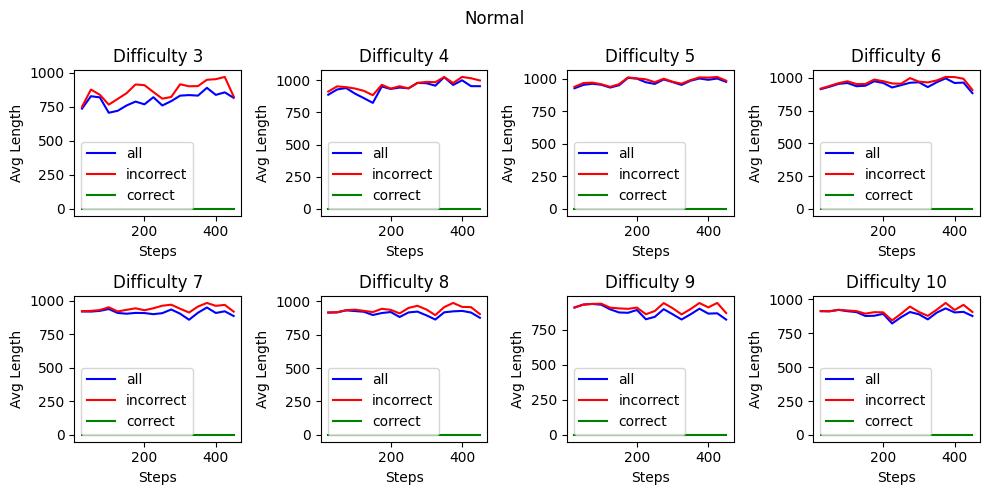

In [87]:
plot_avg_length_by_difficulty([25 * (i + 1) for i in range(450 // 25)], ["/home/cmu/countdown-curriculum/checkpoints/3-8-1024"] * (450 // 25), len_function = lambda x: len(tokenizer.encode(x)), extrapolate = False)

100%|██████████| 18/18 [00:01<00:00, 13.38it/s]


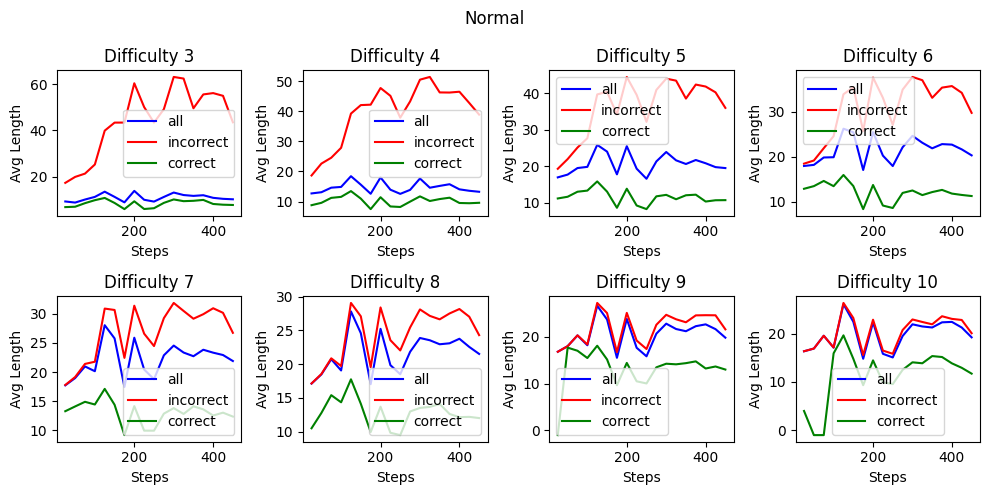

In [8]:
plot_avg_length_by_difficulty([25 * (i + 1) for i in range(450 // 25)], ["/home/cmu/countdown-curriculum/checkpoints/3-8-1024"] * (450 // 25), len_function = lambda x: len(x.split("\n\n")), extrapolate = False)

In [ ]:
            # by difficulty and correctness:
            # p1, p2, p3, ....
            # num_retries = k
            # num_repeats
            # cor

            
            
            attempts = output.split("\n\n")
            num_retries = len(attempts)
            num_repeats = count_repeats(attempts)
            
            # compute the correctness of the attempt
            # each attempt is numerically correct (each number is used once, and the equation evaluates correctly)
            compute_each_correctness(attempts)

            # check if target is reached in this
            correctness_last = attempts[-1].split("\n")[-1]


            # note that this assumes that at leas the model was able to use the m